In [1]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
# import local python modules
import constants as c
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

us_ton_to_ton = 0.907185
miles_to_km = 1.60934

#define scenario input
analysis_year = 2030
shipment_load_attr = 'tons_' + str(analysis_year)
shipment_tonmile_attr = 'tmiles_' + str(analysis_year)

In [2]:
# set plot params
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("white")
sns.set_theme(style="white", font_scale=1.4)

This section load FAF data, aggregated CFS data, SCTG definition and geographic boundaries of study area

In [3]:
#load modeled, FAF and CFS results
# print(c.cfs_distribution_file)
output_dir = 'outputs_Seattle_v2/'
input_dir = 'inputs_Seattle/'
param_dir = 'SynthFirm_parameters/'
plot_dir = 'plot_Seattle_v2/'

faf_data = read_csv('Validation/' + 'FAF5.3.csv', sep = ',')

modeled_data = read_csv(output_dir + 'processed_b2b_flow_summary.csv', sep = ',')
modeled_data = modeled_data.loc[modeled_data['mode_choice'] != 'Other']
#load parameters
sctg_group_lookup = read_csv(param_dir + 'SCTG_Groups_revised.csv', sep = ',')
mesozone_lookup = read_csv(input_dir + 'zonal_id_lookup_final.csv', sep = ',')
# sctg_definition = read_csv(param_dir + 'SCTG_definition.csv', sep = ',')

sctg_names = sctg_group_lookup['SCTG_Name'].unique()
sctg_group_definition = sctg_group_lookup.loc[:, ['SCTG_Group', 'SCTG_Name']]
sctg_group_definition = sctg_group_definition.drop_duplicates()

In [4]:
# process faf data for validation
# region_code = [62, 64, 65, 69]
region_code = [531, 532, 539, 411]
faf_data.loc[:, 'mode_def'] = faf_data.loc[:, 'dms_mode'].map(mode_lookup)
# faf_data = pd.merge(faf_data, sctg_definition, left_on = 'sctg2', right_on = 'SCTG', how = 'left')
faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')
pd.options.mode.chained_assignment = None  # default='warn', turn off annoy warning messages
faf_data.loc[:, 'Distance'] = 1000 * faf_data.loc[:, shipment_tonmile_attr] / faf_data.loc[:, shipment_load_attr]
faf_data.loc[:, shipment_tonmile_attr] *= 1000000 
faf_data = faf_data.dropna(subset = ['Distance'])
faf_data_domestic = faf_data.loc[faf_data['trade_type'] == 1] #select domestic shipment only
faf_data_domestic = \
faf_data_domestic.loc[faf_data_domestic['mode_def'] != 'Other']
faf_outflow = faf_data_domestic.loc[faf_data_domestic['dms_orig'].isin(region_code)]
faf_inflow = faf_data_domestic.loc[faf_data_domestic['dms_dest'].isin(region_code)]
faf_data.head(5)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050,mode_def,SCTG_Code,SCTG_Group,SCTG_Name,Description,Distance
0,NaN,11,11,NaN,NaN,1,NaN,1,1,1,...,6.342501,7.763605,9.571647,11.343818,Truck,1,3,interm_food,Animals and Fish (live),62.055467
1,NaN,11,19,NaN,NaN,1,NaN,1,1,2,...,82.113979,96.869428,116.602924,134.683927,Truck,1,3,interm_food,Animals and Fish (live),124.036281
2,NaN,11,129,NaN,NaN,1,NaN,1,1,3,...,0.564126,0.638719,0.750361,0.844720,Truck,1,3,interm_food,Animals and Fish (live),325.379648
3,NaN,11,131,NaN,NaN,1,NaN,1,1,2,...,3.155784,3.394250,3.850035,4.178881,Truck,1,3,interm_food,Animals and Fish (live),171.439976
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2,...,1.969298,2.141527,2.456208,2.683008,Truck,1,3,interm_food,Animals and Fish (live),244.231799


In [5]:
# process modeled data
# modeled_data.loc[:, 'Distance'] = modeled_data.loc[:, 'tmiles'] / 1000 / modeled_data.loc[:, 'ShipmentLoad']
modeled_region_outflow = modeled_data.loc[modeled_data['outbound'] == 1]
modeled_region_inflow = modeled_data.loc[modeled_data['inbound'] == 1]
modeled_data.head(5)

,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,Commodity_SCTG,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance
0,0,11.0,Birmingham,411.0,Portland (OR),31.0,4.0,mfr_goods,For-hire Truck,3.079254e+06,1.218633,55,0,1,2526.809894
1,1,11.0,Birmingham,411.0,Portland (OR),31.0,4.0,mfr_goods,Rail/IMX,9.216867e+07,34.564865,1560,0,1,2666.542043
2,2,11.0,Birmingham,531.0,Seattle,39.0,4.0,mfr_goods,Air,2.780323e+04,0.013392,17,0,1,2076.068596
3,3,11.0,Birmingham,531.0,Seattle,39.0,4.0,mfr_goods,For-hire Truck,3.869680e+06,1.302199,1653,0,1,2971.650000
4,4,11.0,Birmingham,531.0,Seattle,39.0,4.0,mfr_goods,Rail/IMX,9.396182e+04,0.034662,44,0,1,2710.779209


interm_food


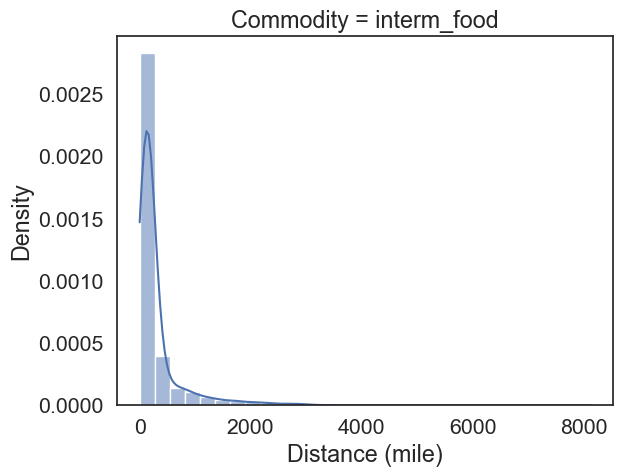

bulk


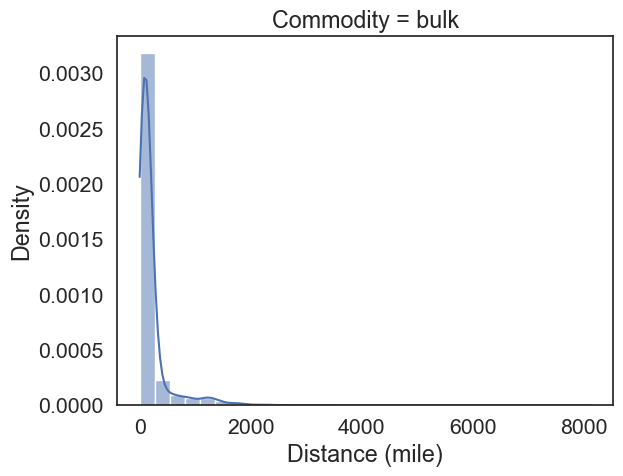

mfr_goods


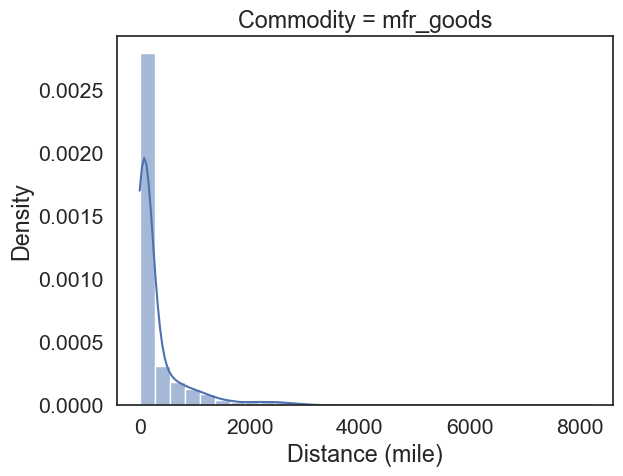

fuel_fert


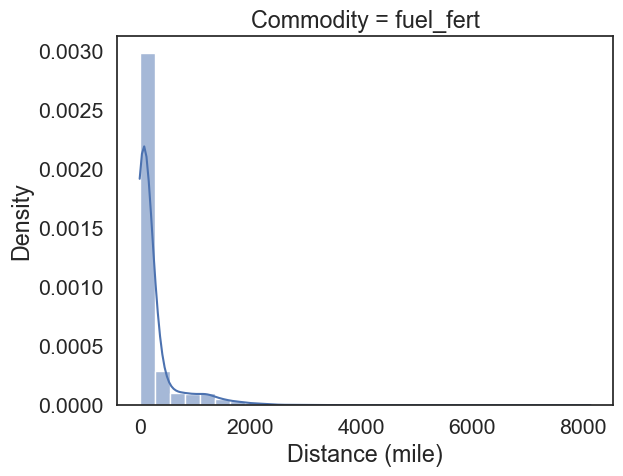

other


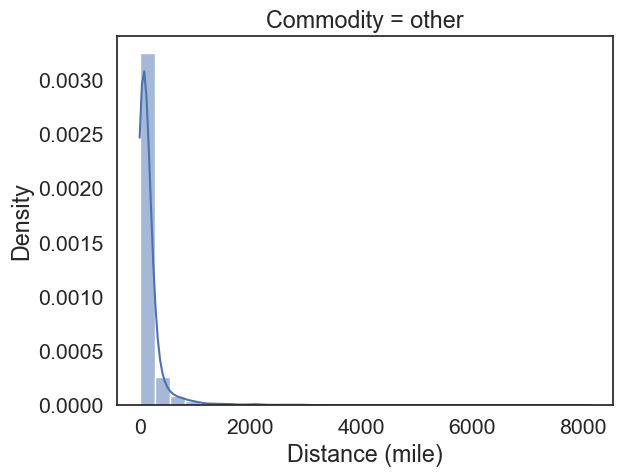

In [6]:
# generate FAF data descriptive statistics by commodity group
summary_statistics = {}
def summary_statistics_generator(data, tonmile_unit_factor = 1000000, shipment_load_unit_factor = 1000, 
                                 distance_var = 'Distance', load_var = 'weight', tonmile_var = 'tmiles'):
    mean_distance = (data[tonmile_var].sum() * tonmile_unit_factor) / \
    (data[load_var].sum() * shipment_load_unit_factor)
    max_distance = data.loc[data[load_var]>0, distance_var].max()
    min_distance = data.loc[data[load_var]>0, distance_var].min()
    data = data.sort_values(distance_var)
    data['weight'] = data[load_var].cumsum()
    cutoff = data[load_var].sum() / 2.0
    median_distance = data.loc[data['weight'] >= cutoff, distance_var].min()
    total_shipment_load = shipment_load_unit_factor * data[load_var].sum() # tons
    return(min_distance, max_distance, mean_distance, median_distance, total_shipment_load)
    
for sctg in sctg_names:
    print(sctg)
    faf_data_to_describe = faf_data_domestic.loc[faf_data_domestic['SCTG_Name'] == sctg]
    min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
    summary_statistics_generator(faf_data_to_describe, 1000000, 1000, 
                                 'Distance', shipment_load_attr, shipment_tonmile_attr)
    summary_statistics[sctg] = [min_distance, max_distance, mean_distance, median_distance]
    sns.histplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, bins = 30, 
             stat="density", kde = True, alpha=0.5)
    plt.title('Commodity = ' + sctg)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig(plot_dir + 'distance_distribution_for ' + sctg + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
summary_statistics_df = pd.DataFrame.from_dict(summary_statistics, orient='index',
                        columns=['min', 'max', 'mean', 'median']) 
summary_statistics_df.to_csv(output_dir + 'FAF_distance_statistics_by_sctg.csv')


In this section, we will compare shipment generation from FAF data, CFS data and modeled shipment data generated by SynthFirm. 

    -FAF: Only domestic shipment data will be selected from FAF.  
    -CFS: same aggregation level as FAF
    -SynthFirm: The SynthFirm modeled data will be filtered by study area.  The truck load will be scaled back to reflect the total shipment from all modes.

Truck


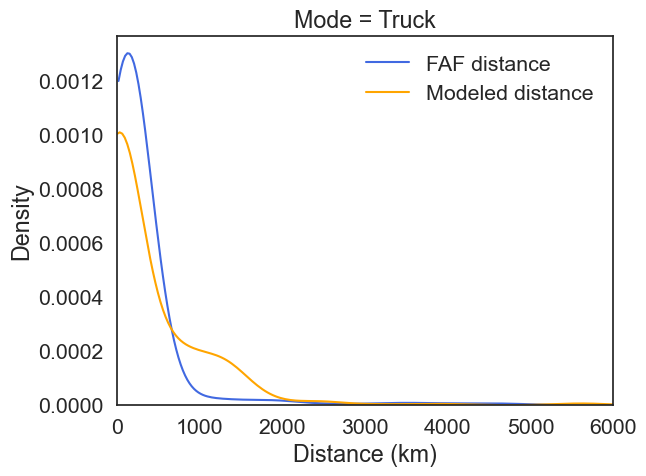

Rail


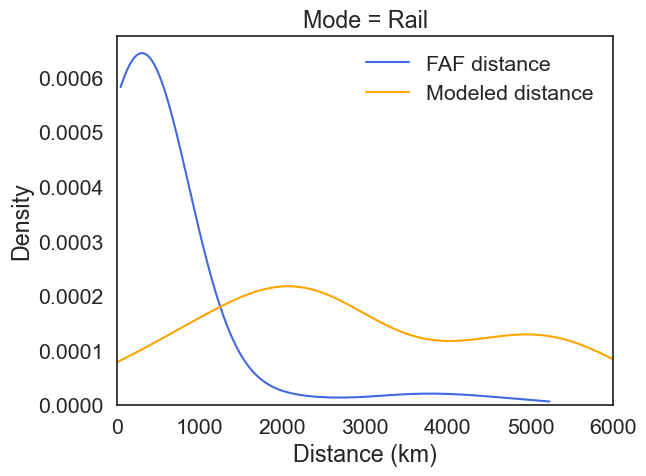

Air


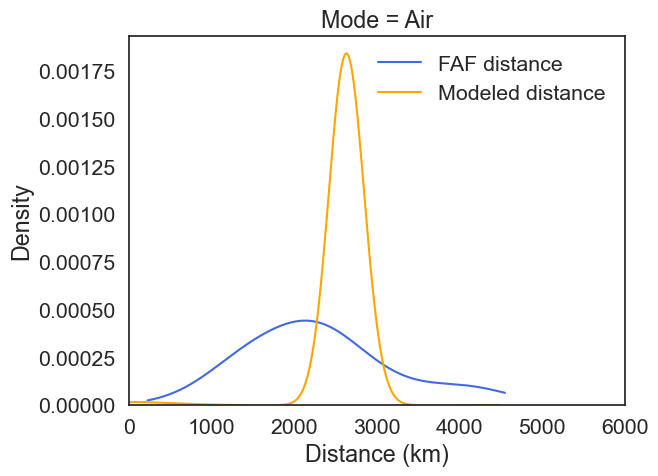

Parcel


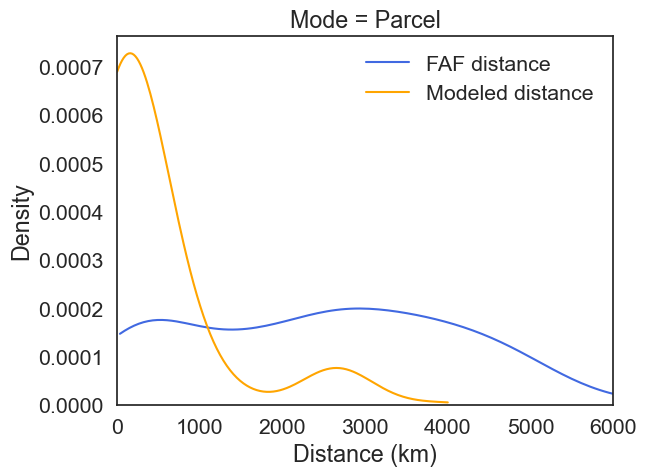

Truck


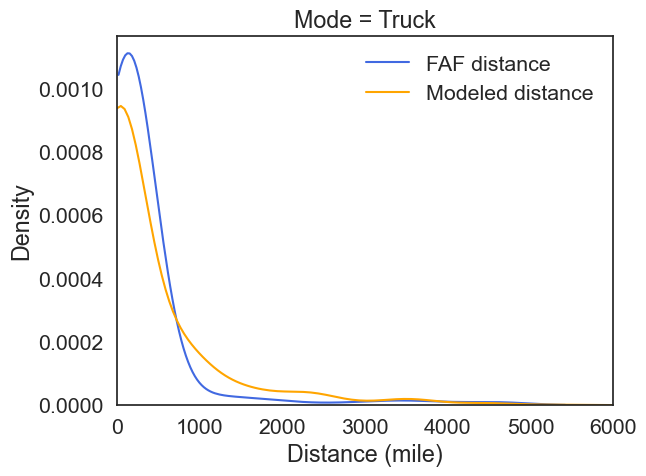

Rail


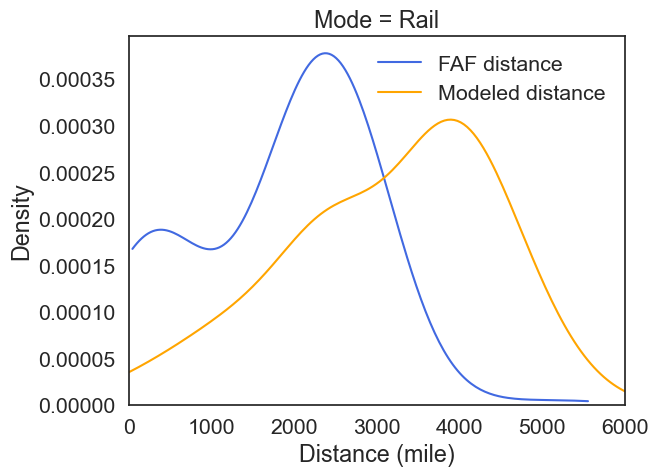

Air


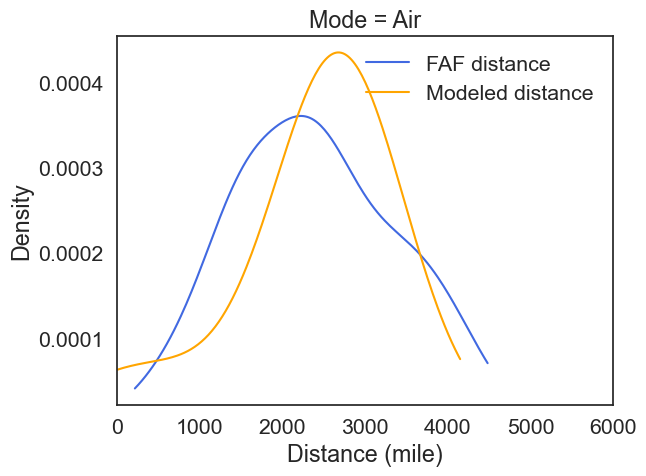

Parcel


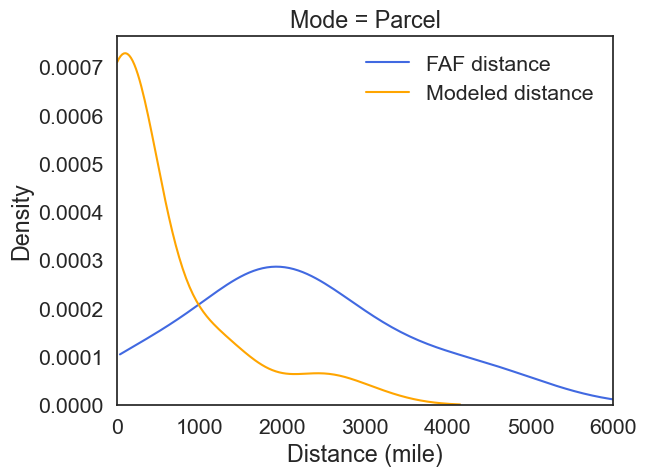

In [7]:
# compare travel distance by mode
modeled_statistics_mode = {}
FAF_mode_mapping = {'Truck':['For-hire Truck', 'Private Truck'], 'Rail':['Rail/IMX'], 
                    'Air': ['Air'], 'Parcel':['Parcel']}

mode_choice = modeled_data['mode_choice'].unique()


# production
modeled_statistics_mode = {}
for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
    print(mode)
    mode_to_select = FAF_mode_mapping[mode]
    modeled_data_to_describe = modeled_region_outflow.loc[modeled_region_outflow['mode_choice'].isin(mode_to_select)]  
    faf_data_to_describe = faf_outflow.loc[faf_outflow['mode_def'] == mode]
    faf_data_to_describe.loc[:, 'Distance'] *= miles_to_km
    modeled_data_to_describe.loc[:, 'Distance'] *= miles_to_km
    sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
            color = 'royalblue')     
    sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
            color = 'orange')
    plt.xlim([0, 6000])
    plt.legend(['FAF distance', 'Modeled distance'])
    plt.title('Mode = ' + mode)
    plt.xlabel('Distance (km)')
    plt.ylabel('Density')
    plt.savefig(plot_dir + 'outflow_distance_comparison_for ' + mode + '_forecast.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    

# attraction
for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
    print(mode)
    mode_to_select = FAF_mode_mapping[mode]
    modeled_data_to_describe = modeled_region_inflow.loc[modeled_region_inflow['mode_choice'].isin(mode_to_select)]
    
    faf_data_to_describe = faf_inflow.loc[faf_inflow['mode_def'] == mode]
    faf_data_to_describe.loc[:, 'Distance'] *= miles_to_km
    modeled_data_to_describe.loc[:, 'Distance'] *= miles_to_km   
    sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
    sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
    plt.xlim([0, 6000])
    plt.legend(['FAF distance', 'Modeled distance'])
    plt.title('Mode = ' + mode)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig(plot_dir + 'inflow_distance_comparison_for ' + mode + '_forecast.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
# modeled_statistics_mode_df = pd.DataFrame.from_dict(modeled_statistics_mode, orient='index',
#                         columns=['min', 'max', 'mean', 'median', 'load (ton)']) 
# modeled_statistics_mode_df.to_csv(c.output_dir + 'modeled_inflow_distance_statistics_by_mode.csv')

FAF shipment        393082.094232
Modeled shipment    409213.841894
dtype: float64
FAF tonmile         92122.904783
Modeled tonmile    146910.268312
dtype: float64


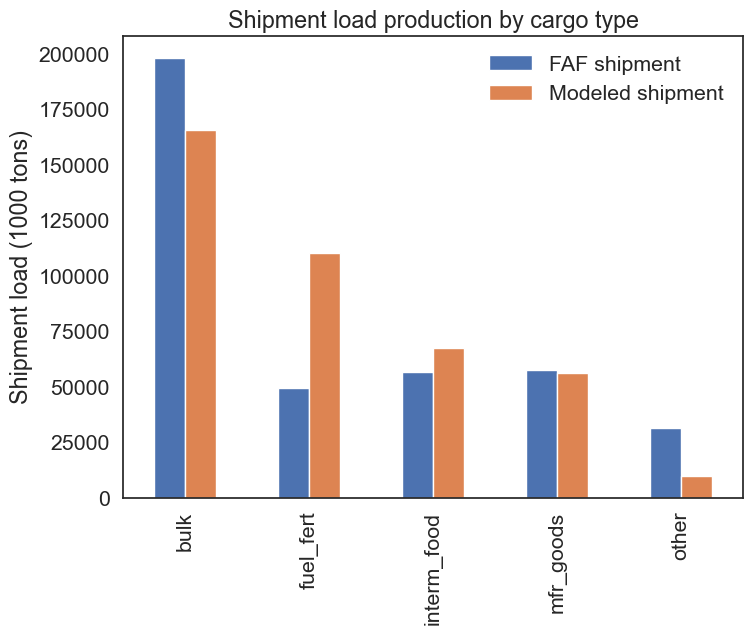

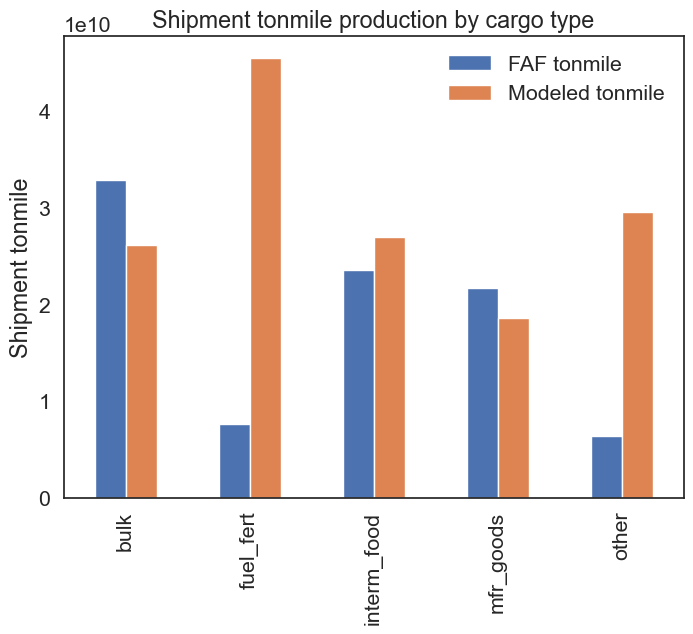

In [8]:
### plot shipment generation by commodity group
# data aggregation
FAF_shipment_by_sctg = faf_outflow.groupby('SCTG_Name')[[shipment_load_attr, shipment_tonmile_attr]].sum()
modeled_shipment_by_sctg = modeled_region_outflow.groupby('SCTG_Name')[['ShipmentLoad', 'tmiles']].sum()

shipment_generation_by_sctg = pd.merge(FAF_shipment_by_sctg, modeled_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_generation_by_sctg.columns = ['FAF shipment', 'FAF tonmile', 
                                       'Modeled shipment', 'Modeled tonmile']

shipment_generation_by_sctg.loc[:, 'FAF shipment'] *= us_ton_to_ton
shipment_generation_by_sctg.loc[:, 'Modeled shipment'] *= us_ton_to_ton

print(shipment_generation_by_sctg.loc[:, ['FAF shipment', 'Modeled shipment']].sum())
print(shipment_generation_by_sctg.loc[:, ['FAF tonmile', 'Modeled tonmile']].sum()/1000000)
# plot bar chart
shipment_generation_by_sctg.plot(y = ['FAF shipment', 'Modeled shipment'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment load production by cargo type')
plt.xlabel('')
plt.ylabel('Shipment load (1000 tons)')
plt.legend(loc=1)
plt.savefig(plot_dir + 'outflow_shipment_comparison_by_sctg_forecast.png', bbox_inches='tight', dpi = 300)
plt.show()


shipment_generation_by_sctg.plot(y = ['FAF tonmile', 'Modeled tonmile'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment tonmile production by cargo type')
plt.xlabel('')
plt.ylabel('Shipment tonmile')
plt.legend(loc=1)
plt.savefig(plot_dir + 'outflow_tonmile_comparison_by_sctg_forecast.png', bbox_inches='tight', dpi = 300)
plt.show()

FAF shipment        435956.322850
Modeled shipment    430497.759753
dtype: float64
FAF tonmile        163552.753122
Modeled tonmile    213912.245677
dtype: float64


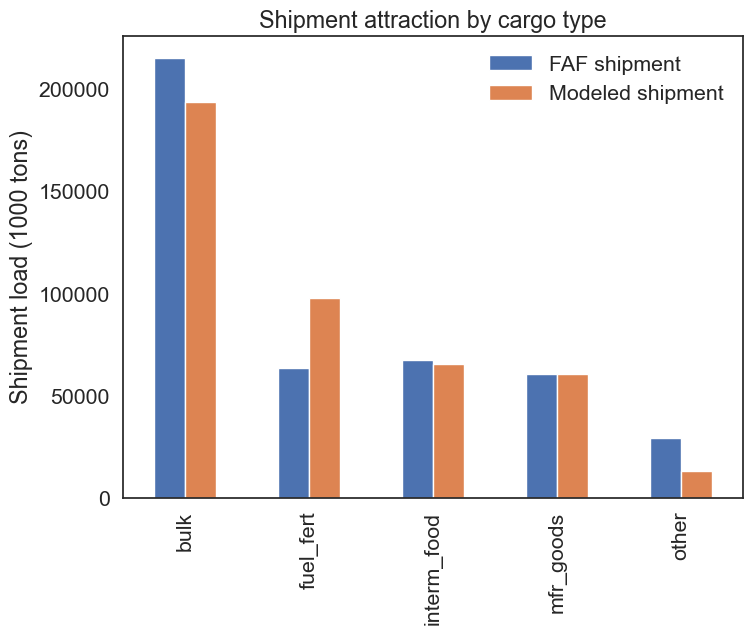

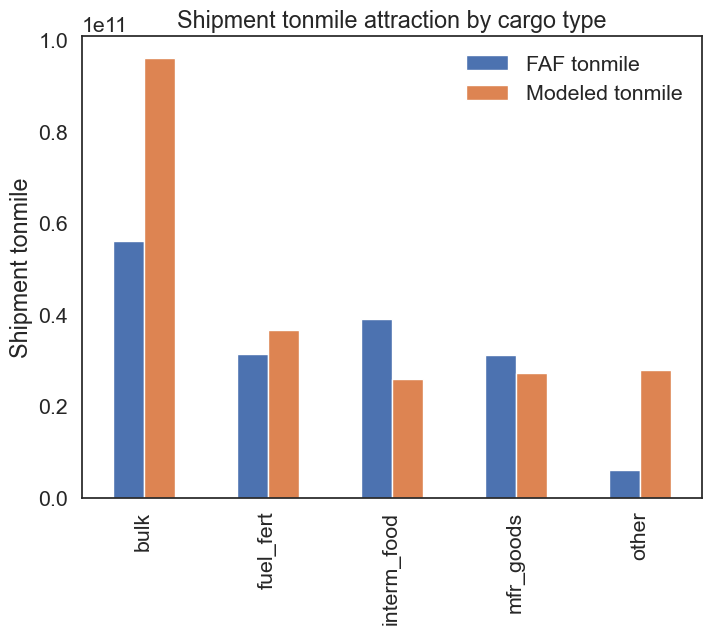

In [9]:
### plot shipment generation by commodity group
# data aggregation

FAF_shipment_by_sctg = faf_inflow.groupby('SCTG_Name')[[shipment_load_attr, shipment_tonmile_attr]].sum()
modeled_shipment_by_sctg = modeled_region_inflow.groupby('SCTG_Name')[['ShipmentLoad', 'tmiles']].sum()


shipment_attraction_by_sctg = pd.merge(FAF_shipment_by_sctg, modeled_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_attraction_by_sctg.columns = ['FAF shipment', 'FAF tonmile', 
                                       'Modeled shipment', 'Modeled tonmile']

shipment_attraction_by_sctg.loc[:, 'FAF shipment'] *= us_ton_to_ton
shipment_attraction_by_sctg.loc[:, 'Modeled shipment'] *= us_ton_to_ton

print(shipment_attraction_by_sctg.loc[:, ['FAF shipment', 'Modeled shipment']].sum())
print(shipment_attraction_by_sctg.loc[:, ['FAF tonmile', 'Modeled tonmile']].sum()/1000000)
# plot bar chart
shipment_attraction_by_sctg.plot(y = ['FAF shipment',  'Modeled shipment'], 
                                 figsize = (8, 6), kind = 'bar',  title = 'Shipment attraction by cargo type')
plt.xlabel('')
plt.ylabel('Shipment load (1000 tons)')
plt.legend(loc=1)
plt.savefig(plot_dir + 'inflow_shipment_comparison_by_sctg_forecast.png', bbox_inches='tight', dpi = 300)
plt.show()

shipment_attraction_by_sctg.plot(y = ['FAF tonmile', 'Modeled tonmile'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment tonmile attraction by cargo type')
plt.xlabel('')
plt.ylabel('Shipment tonmile')
plt.legend(loc=1)
plt.savefig(plot_dir + 'inflow_tonmile_comparison_by_sctg_forecast.png', bbox_inches='tight', dpi = 300)
plt.show()

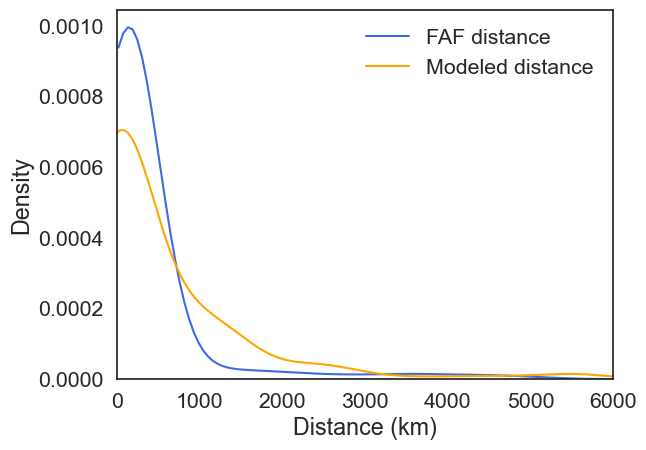

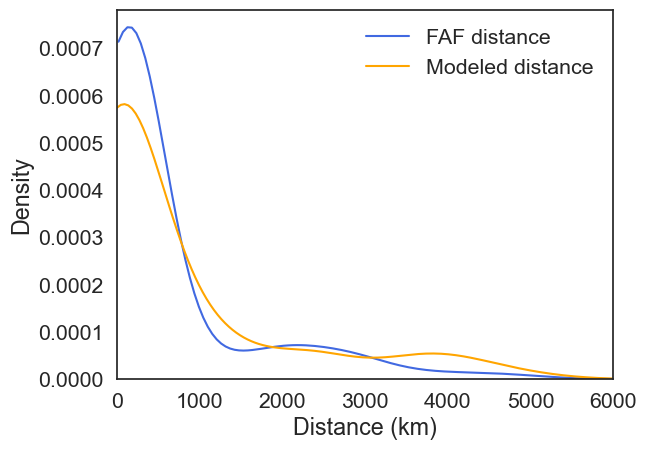

In [10]:
# KDE plot
faf_outflow['Distance'] *= miles_to_km
modeled_region_outflow['Distance'] *= miles_to_km

sns.kdeplot(data = faf_outflow, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
sns.kdeplot(data = modeled_region_outflow, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
plt.xlim([0, 6000])
plt.legend(['FAF distance', 'Modeled distance'])
plt.xlabel('Distance (km)')
plt.ylabel('Density')
plt.savefig(plot_dir + 'outflow_distance_comparison_kde_forecast.png', bbox_inches = 'tight', dpi = 200)
plt.show()

faf_inflow['Distance'] *= miles_to_km
modeled_region_inflow['Distance'] *= miles_to_km

sns.kdeplot(data = faf_inflow, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
sns.kdeplot(data = modeled_region_inflow, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
plt.xlim([0, 6000])
plt.legend(['FAF distance', 'Modeled distance'])
plt.xlabel('Distance (km)')
plt.ylabel('Density')
plt.savefig(plot_dir + 'inflow_distance_comparison_kde_forecast.png', bbox_inches = 'tight', dpi = 200)
plt.show()

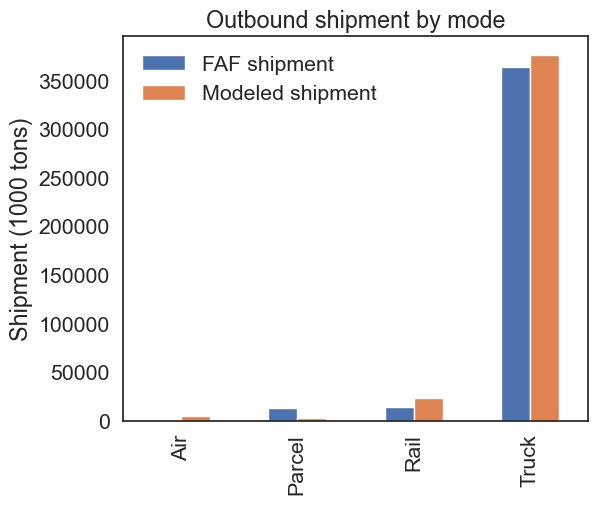

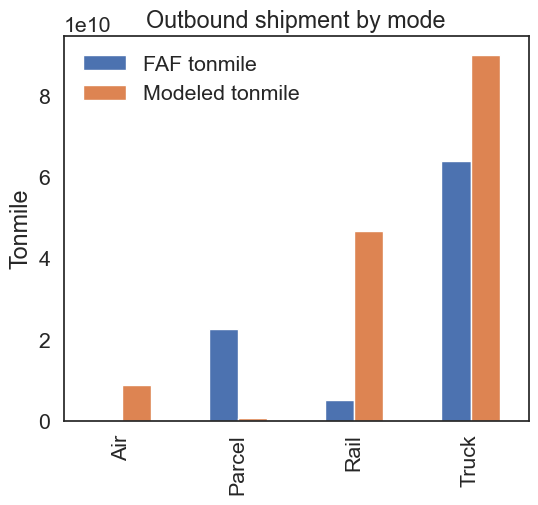

In [11]:
# plot shipment production by mode choice
model_to_FAF_mapping = {'For-hire Truck':'Truck', 
                      'Private Truck': 'Truck', 
                      'Rail/IMX': 'Rail', 
                      'Air':'Air', 
                      'Parcel':'Parcel'}
modeled_region_outflow.loc[:, 'mode_def'] = modeled_region_outflow.loc[:, 'mode_choice'].map(model_to_FAF_mapping)
    
agg_faf_outflow_by_mode = faf_outflow.groupby(['mode_def'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_outflow_by_mode = agg_faf_outflow_by_mode.reset_index()

agg_modeled_outflow_by_mode = modeled_region_outflow.groupby(['mode_def'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_outflow_by_mode = agg_modeled_outflow_by_mode.reset_index()
compare_outflow_by_mode = pd.merge(agg_faf_outflow_by_mode, agg_modeled_outflow_by_mode, 
                                         on = ['mode_def'], how = 'left')

compare_outflow_by_mode.head(5)
compare_outflow_by_mode.columns = ['mode_def', 'FAF shipment', 'FAF tonmile',                                       
                                  'Modeled shipment', 'Modeled tonmile']
compare_outflow_by_mode = \
compare_outflow_by_mode.loc[compare_outflow_by_mode['mode_def'] != 'Other']

compare_outflow_by_mode['FAF shipment'] *= us_ton_to_ton
compare_outflow_by_mode['Modeled shipment'] *= us_ton_to_ton

# compare_outflow_by_mode = compare_outflow_by_mode.rename(columns={shipment_load_attr:'FAF shipment', 
#                                                                               'ShipmentLoad':'modeled shipment',
#                                                                              'wgted_wght_ton_th':'CFS shipment'})
compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF shipment', 'Modeled shipment'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Outbound shipment by mode')

plt.xlabel('')
plt.ylabel('Shipment (1000 tons)')
plt.legend(loc=2)
plt.savefig(plot_dir + 'outflow_shipment_comparison_by_mode_forecast.png', bbox_inches='tight', dpi = 300)
plt.show()


compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF tonmile', 'Modeled tonmile'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Outbound shipment by mode')

plt.xlabel('')
plt.ylabel('Tonmile')
plt.legend(loc=2)
plt.savefig(plot_dir + 'outflow_tonmile_comparison_by_mode_forecast.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_outflow_by_mode.to_csv(output_dir + 'outflow_shipment_by_mode_comparison_forecast.csv')

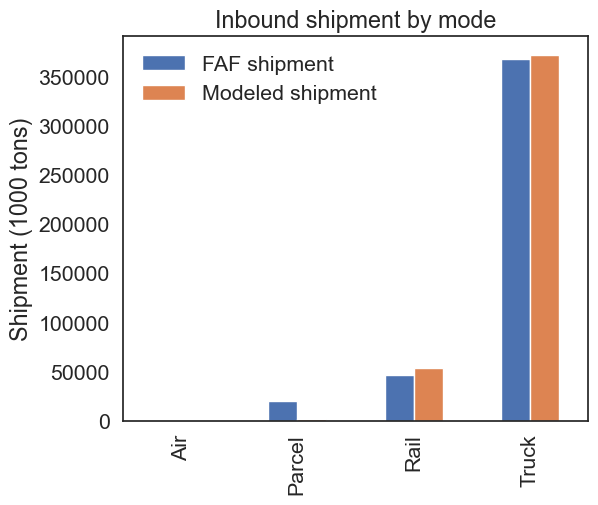

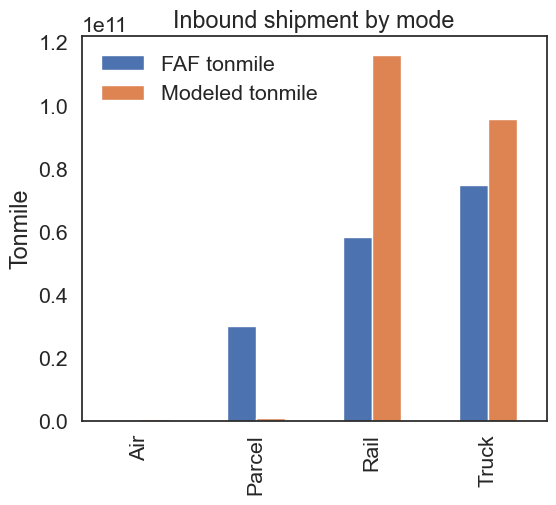

In [12]:
# plot shipment attraction by mode choice

modeled_region_inflow.loc[:, 'mode_def'] = modeled_region_inflow.loc[:, 'mode_choice'].map(model_to_FAF_mapping)
    
agg_faf_inflow_by_mode = faf_inflow.groupby(['mode_def'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_inflow_by_mode = agg_faf_inflow_by_mode.reset_index()

agg_modeled_inflow_by_mode = modeled_region_inflow.groupby(['mode_def'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_inflow_by_mode = agg_modeled_inflow_by_mode.reset_index()
compare_inflow_by_mode = pd.merge(agg_faf_inflow_by_mode, agg_modeled_inflow_by_mode, 
                                         on = ['mode_def'], how = 'left')

compare_inflow_by_mode.head(5)
compare_inflow_by_mode.columns = ['mode_def', 'FAF shipment', 'FAF tonmile',                                       
                                  'Modeled shipment', 'Modeled tonmile']

compare_inflow_by_mode = \
compare_inflow_by_mode.loc[compare_inflow_by_mode['mode_def'] != 'Other']

compare_inflow_by_mode['FAF shipment'] *= us_ton_to_ton
compare_inflow_by_mode['Modeled shipment'] *= us_ton_to_ton
# compare_outflow_by_mode = compare_outflow_by_mode.rename(columns={shipment_load_attr:'FAF shipment', 
#                                                                               'ShipmentLoad':'modeled shipment',
#                                                                              'wgted_wght_ton_th':'CFS shipment'})
compare_inflow_by_mode.plot(x= 'mode_def', 
                            y = ['FAF shipment', 'Modeled shipment'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Inbound shipment by mode')

plt.xlabel('')
plt.ylabel('Shipment (1000 tons)')
plt.legend(loc=2)
plt.savefig(plot_dir + 'inflow_shipment_comparison_by_mode_forecast.png', bbox_inches='tight', dpi = 300)
plt.show()


compare_inflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF tonmile', 'Modeled tonmile'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Inbound shipment by mode')

plt.xlabel('')
plt.ylabel('Tonmile')
plt.legend(loc=2)
plt.savefig(plot_dir + 'inflow_tonmile_comparison_by_mode_forecast.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_inflow_by_mode.to_csv(output_dir + 'inflow_shipment_by_mode_comparison.csv')

   orig_FAFID   orig_FAFNAME   ShipmentLoad
0       411.0  Portland (OR)   93438.721763
1       531.0        Seattle  166653.401001
2       532.0  Portland (WA)   24915.252986
3       539.0     Rest of WA  166073.541477


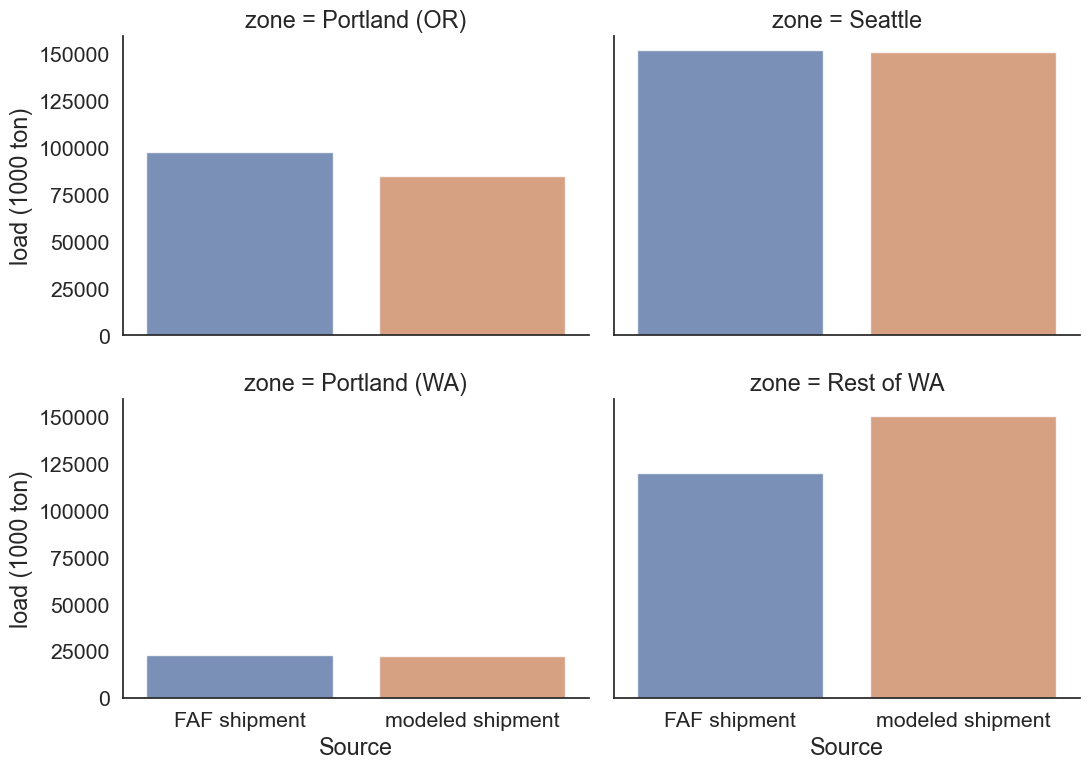

In [13]:
# plot shipment comparison by origin FAF zone and commodity group
agg_faf_outflow_by_zone = faf_outflow.groupby(['dms_orig'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_zone = agg_faf_outflow_by_zone.reset_index()
agg_modeled_outflow_by_zone = modeled_region_outflow.groupby(['orig_FAFID', 'orig_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_outflow_by_zone = agg_modeled_outflow_by_zone.reset_index()
print(agg_modeled_outflow_by_zone)
                                                                      
compare_outflow_by_zone = pd.merge(agg_faf_outflow_by_zone, agg_modeled_outflow_by_zone, 
                                         left_on = ['dms_orig'], right_on = ['orig_FAFID'], how = 'left')
compare_outflow_by_zone = compare_outflow_by_zone.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                              'ShipmentLoad':'modeled shipment'})
compare_outflow_by_zone = pd.melt(compare_outflow_by_zone, 
                                    id_vars=['dms_orig', 'orig_FAFID', 'orig_FAFNAME'], 
                                    value_vars=['FAF shipment', 'modeled shipment'], 
                                    var_name = 'Source', ignore_index=False)
# print(compare_outflow_by_zone.head(5))

compare_outflow_by_zone = \
compare_outflow_by_zone.rename(columns = {'orig_FAFNAME': 'zone',
                                          'value': 'load (1000 ton)'})
compare_outflow_by_zone['load (1000 ton)'] *= us_ton_to_ton
ax = sns.catplot(
    data= compare_outflow_by_zone, kind="bar",
    x="Source", y="load (1000 ton)", col = 'zone', col_wrap = 2,
    alpha=.8, height=4, aspect=1.4
)
# ax.set_xticklabels(rotation=30) 
plt.savefig(plot_dir + 'outflow_shipment_by_zone_forecast.png', 
            bbox_inches='tight', dpi = 300)
plt.ylabel('Shipment load (1000 tons)')
plt.show()
compare_outflow_by_zone.to_csv(output_dir + 'compare_outflow_by_zone_forecast.csv', sep = ',')

   dest_FAFID   dest_FAFNAME   ShipmentLoad
0       411.0  Portland (OR)  124236.429683
1       531.0        Seattle  175528.657777
2       532.0  Portland (WA)   44405.912234
3       539.0     Rest of WA  130371.414205


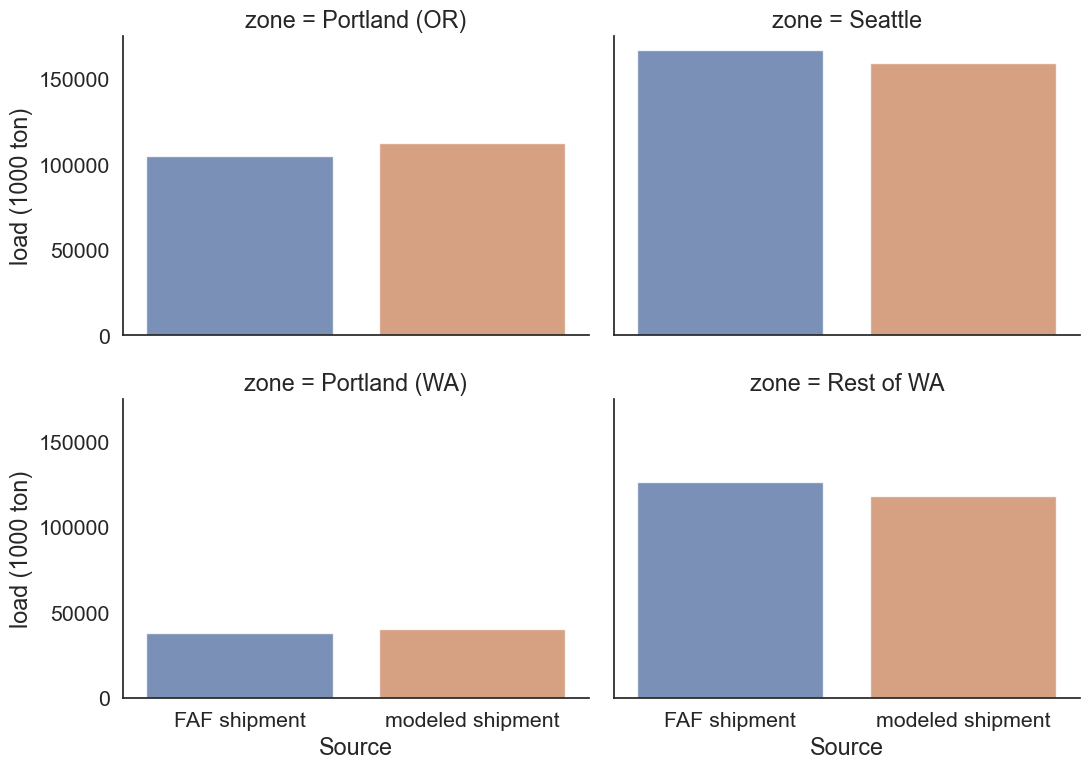

In [14]:
# plot shipment comparison by origin FAF zone and commodity group
agg_faf_inflow_by_zone = faf_inflow.groupby(['dms_dest'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_zone = agg_faf_inflow_by_zone.reset_index()

agg_modeled_inflow_by_zone = modeled_region_inflow.groupby(['dest_FAFID', 'dest_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_inflow_by_zone = agg_modeled_inflow_by_zone.reset_index()
print(agg_modeled_inflow_by_zone)
                                                                      
compare_inflow_by_zone = pd.merge(agg_faf_inflow_by_zone, agg_modeled_inflow_by_zone, 
                                         left_on = ['dms_dest'], right_on = ['dest_FAFID'], how = 'left')

compare_inflow_by_zone = compare_inflow_by_zone.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                              'ShipmentLoad':'modeled shipment'})
compare_inflow_by_zone = pd.melt(compare_inflow_by_zone, 
                                        id_vars=['dms_dest', 'dest_FAFID', 'dest_FAFNAME'], 
                                        value_vars=['FAF shipment', 'modeled shipment'], 
                                        var_name = 'Source', ignore_index=False)
# print(compare_inflow_by_zone.head(5))
compare_inflow_by_zone = compare_inflow_by_zone.rename(columns = {'dest_FAFNAME': 'zone',
                                                                   'value': 'load (1000 ton)'})
compare_inflow_by_zone['load (1000 ton)'] *= us_ton_to_ton
ax = sns.catplot(
    data= compare_inflow_by_zone, kind="bar",
    x="Source", y="load (1000 ton)", col = 'zone', col_wrap = 2,
    alpha=.8, height=4, aspect=1.4
)
# ax.set_xticklabels(rotation=30) 
plt.savefig(plot_dir + 'inflow_shipment_by_zone_forecast.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_inflow_by_zone.to_csv(output_dir + 'compare_inflow_by_zone_forecast.csv', sep = ',')

In this section, we will compare the shipment distribution (O-D flow) among FAF data, CFS data and model output. Two types of comparisons will be generated in this process:

    - Shipment comparison by origin/destination (showing top 20 origins/destinations)
    - Comparison of shipment distance distributions


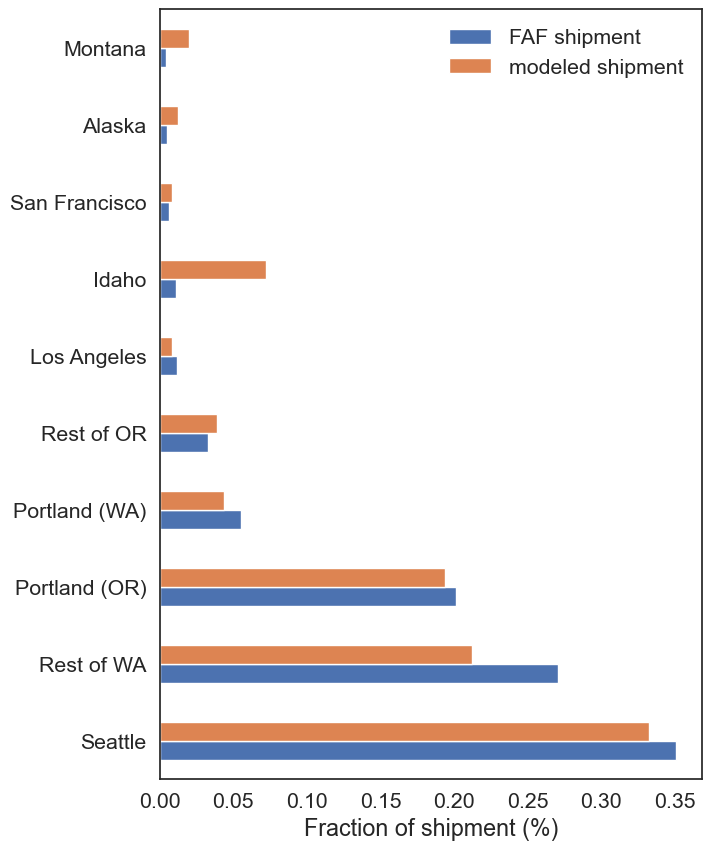

In [15]:
# plot outflow distance and tonnage distribution
nzones = 10
agg_faf_outflow_by_destination = faf_outflow.groupby(['dms_dest'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_destination = agg_faf_outflow_by_destination.reset_index()
agg_modeled_outflow_destination = modeled_region_outflow.groupby(['dest_FAFID', 'dest_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_outflow_destination = agg_modeled_outflow_destination.reset_index()

                                                                      
compare_outflow_by_destination = pd.merge(agg_faf_outflow_by_destination, agg_modeled_outflow_destination, 
                                         left_on = ['dms_dest'], right_on = ['dest_FAFID'], how = 'left')


compare_outflow_by_destination = \
compare_outflow_by_destination.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                                'ShipmentLoad':'modeled shipment'})
compare_outflow_by_destination.loc[:, 'FAF shipment'] = \
compare_outflow_by_destination.loc[:, 'FAF shipment'] / compare_outflow_by_destination.loc[:, 'FAF shipment'].sum()
compare_outflow_by_destination.loc[:, 'modeled shipment'] = \
compare_outflow_by_destination.loc[:, 'modeled shipment'] / compare_outflow_by_destination.loc[:, 'modeled shipment'].sum()

# sns.scatterplot(data=compare_outflow_by_destination, x="FAF_shipment", y="modeled_shipment")
# plot load assignment (top 20 zones)
compare_outflow_by_destination = compare_outflow_by_destination.sort_values('FAF shipment', ascending = False)
compare_outflow_by_destination_to_plot = compare_outflow_by_destination.head(nzones)
compare_outflow_by_destination_to_plot.plot.barh(x='dest_FAFNAME', y=['FAF shipment', 'modeled shipment'], 
                                         figsize = (7,10), rot = 0)
plt.xlabel('Fraction of shipment (%)')
plt.ylabel('')
plt.savefig(plot_dir + 'percent_outflow_load_comparison_forecast.png', bbox_inches = 'tight', dpi = 200)
plt.show()


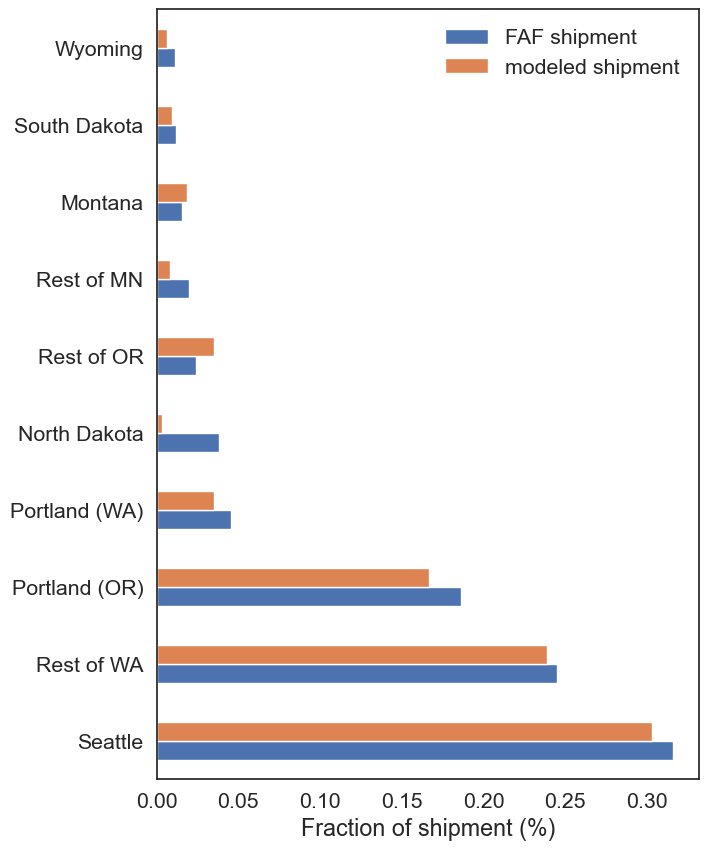

In [16]:
# plot inflow distance and tonnage distribution
nzones = 10
agg_faf_inflow_by_origin = faf_inflow.groupby(['dms_orig'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_origin = agg_faf_inflow_by_origin.reset_index()
agg_modeled_inflow_origin = modeled_region_inflow.groupby(['orig_FAFID', 'orig_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_inflow_origin = agg_modeled_inflow_origin.reset_index()

                                                                      
compare_inflow_by_origin = pd.merge(agg_faf_inflow_by_origin, agg_modeled_inflow_origin, 
                                         left_on = ['dms_orig'], right_on = ['orig_FAFID'], how = 'left')



compare_inflow_by_origin = compare_inflow_by_origin.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                                'ShipmentLoad':'modeled shipment'})


compare_inflow_by_origin.loc[:, 'FAF shipment'] = compare_inflow_by_origin.loc[:, 'FAF shipment'] / compare_inflow_by_origin.loc[:, 'FAF shipment'].sum()
compare_inflow_by_origin.loc[:, 'modeled shipment'] = compare_inflow_by_origin.loc[:, 'modeled shipment'] / compare_inflow_by_origin.loc[:, 'modeled shipment'].sum()

# plot load assignment (top 20 zones)
compare_inflow_by_origin = compare_inflow_by_origin.sort_values('FAF shipment', ascending = False)
compare_inflow_by_origin_to_plot = compare_inflow_by_origin.head(nzones)
compare_inflow_by_origin_to_plot.plot.barh(x='orig_FAFNAME', y=['FAF shipment', 'modeled shipment'], 
                                         figsize = (7,10), rot = 0)
plt.xlabel('Fraction of shipment (%)')
plt.ylabel('')
plt.savefig(plot_dir + 'percent_inflow_load_comparison_forecast.png', bbox_inches = 'tight', dpi = 200)
plt.show()


In [19]:
import numpy as np
print(np.__version__)
print(pd.__version__)

1.20.3
2.0.3
